# Model Building

In [1]:
# Import libraries
import pandas as pd
import boto3
import sagemaker
from pyathena import connect
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from time import gmtime, strftime, sleep
from sagemaker.model import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# View created feature groups
!aws sagemaker list-feature-groups

{
    "FeatureGroupSummaries": [
        {
            "FeatureGroupName": "foodlens-products-feature-group-12-23-30-35",
            "FeatureGroupArn": "arn:aws:sagemaker:us-east-1:381492037991:feature-group/foodlens-products-feature-group-12-23-30-35",
            "CreationTime": "2025-10-12T23:30:42.662000+00:00",
            "FeatureGroupStatus": "Created",
            "OfflineStoreStatus": {
                "Status": "Active"
            }
        },
        {
            "FeatureGroupName": "foodlens-products-feature-group-03-06-06-04",
            "FeatureGroupArn": "arn:aws:sagemaker:us-east-1:381492037991:feature-group/foodlens-products-feature-group-03-06-06-04",
            "CreationTime": "2025-10-03T06:06:07.254000+00:00",
            "FeatureGroupStatus": "Created",
            "OfflineStoreStatus": {
                "Status": "Active"
            }
        }
    ]
}


In [25]:
# Change this to your feature group (ex. "foodlens-products-feature-group-30-14-49-50")
# feature_group_name = None
feature_group_name = "foodlens-products-feature-group-12-23-30-35"
assert feature_group_name is not None

In [4]:
# Initialize SageMaker session and Feature Group
# Setup boto and sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sess)
prefix = "nutriscore-prediction-xgboost"

# Initialize athena query staging
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create connection to Athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [5]:
import boto3
sm_client = boto3.client('sagemaker', region_name=region)

response = sm_client.list_feature_groups()
for fg in response['FeatureGroupSummaries']:
    print(fg['FeatureGroupName'], "|", fg['FeatureGroupStatus'])


foodlens-products-feature-group-12-23-30-35 | Created
foodlens-products-feature-group-03-06-06-04 | Created


In [7]:
from sagemaker.feature_store.feature_group import FeatureGroup
import sagemaker

# Use the existing Feature Group name
feature_group_name = "foodlens-products-feature-group-12-23-30-35"

# Connect to SageMaker Feature Store
session = sagemaker.Session()
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=session)

# Describe feature group and get key attributes
record_id_name = feature_group.describe()['RecordIdentifierFeatureName']
query = feature_group.athena_query()
table_name = query.table_name

print(f"Athena Table Name: {table_name}")
print(f"Record Identifier: {record_id_name}")


Athena Table Name: foodlens_products_feature_group_12_23_30_35_1760311842
Record Identifier: code


In [8]:
# Verify 100k unique records in feature store
statement = """SELECT COUNT(DISTINCT "code") 
FROM sagemaker_featurestore.{}""".format(table_name)
print(statement)
df = pd.read_sql(statement, conn)
df

SELECT COUNT(DISTINCT "code") 
FROM sagemaker_featurestore.foodlens_products_feature_group_12_23_30_35_1760311842


/tmp/ipykernel_283/3127886201.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,_col0
0,100000


## Prepare Dataset Splits

In [9]:
# Split data into training/testing/validation/production sets

# Base query template
# We use xxhash64 for its speed. It creates a deterministic hash for each record ID.
query_template = f"""
SELECT *
FROM "{table_name}"
WHERE MOD(ABS(from_big_endian_64(xxhash64(CAST("{record_id_name}" AS VARBINARY)))), 100)
"""

# --- Training Data (40%) ---
train_query_string = query_template + " BETWEEN 0 AND 39"
train_query = feature_group.athena_query()
train_query.run(query_string=train_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/train/')
train_query.wait()
train_df = train_query.as_dataframe(dtype={0: str}) # code col as str

# --- Production Data (40%) ---
prod_query_string = query_template + " BETWEEN 40 AND 79"
prod_query = feature_group.athena_query()
prod_query.run(query_string=prod_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/prod/')
prod_query.wait()
prod_df = prod_query.as_dataframe()

# --- Test Data (10%) ---
test_query_string = query_template + " BETWEEN 80 AND 89"
test_query = feature_group.athena_query()
test_query.run(query_string=test_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/test/')
test_query.wait()
test_df = test_query.as_dataframe()

# --- Validation Data (10%) ---
validation_query_string = query_template + " BETWEEN 90 AND 99"
validation_query = feature_group.athena_query()
validation_query.run(query_string=validation_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/validation/')
validation_query.wait()
val_df = validation_query.as_dataframe()

# Verify the shapes of the resulting DataFrames
print(f"Training set shape:   {train_df.shape}")
print(f"Production set shape: {prod_df.shape}")
print(f"Test set shape:       {test_df.shape}")
print(f"Validation set shape: {val_df.shape}")

Training set shape:   (39955, 30)
Production set shape: (39992, 30)
Test set shape:       (9962, 30)
Validation set shape: (10091, 30)


In [10]:
# View training data samples
pd.set_option('display.max_columns', None)
train_df.head(3)

,code,product_name,nova_group,additives_n,ingredients_n,nutriscore_score,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,sugars_100g,saturated_fat_100g,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,nutrition_score_fr_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g,eventtime,write_time,api_invocation_time,is_deleted
0,4902124680235,Nobel Sour Lemon Flavor Candy,4,3,10,19,1648.0,0.000000,100.00,0.000,0.000000,0.00,11.111111,100.00,0.00,0.0,0.27,0.00,11.111111,394.0,4.0,19.0,0.000000e+00,0.000000e+00,0.000000,0.000000,1.760312e+09,2025-10-12 23:39:43.060,2025-10-12 23:34:42.000,False
1,0041349820621,Marinara Pasta Sauce,3,0,8,0,135.0,0.000368,3.84,0.000,0.000147,0.64,7.519531,1.92,0.00,0.0,1.60,0.64,18.457031,32.3,3.0,0.0,1.440000e-10,6.880000e-07,0.000026,0.000012,1.760312e+09,2025-10-12 23:39:43.060,2025-10-12 23:34:42.000,False
2,0041497102976,Weis,4,17,74,18,1393.0,0.980000,45.10,0.029,0.392000,2.00,1.484375,19.61,5.88,0.0,13.73,5.88,1.484375,333.0,4.0,18.0,1.764000e-04,2.120000e-03,0.000000,0.000000,1.760312e+09,2025-10-12 23:39:43.060,2025-10-12 23:34:42.000,False


## Data Preprocessing

In [11]:
# Feature selection
target = 'nutriscore_score'
cols_to_drop = [
    target,
    'code',
    'product_name',
    'nutrition_score_fr_100g', # data leakage
    'eventtime',
    'write_time',
    'api_invocation_time',
    'is_deleted']

# Set training data
y_train = train_df[target]
X_train = train_df.drop(columns=cols_to_drop)

# Set testing data
y_test = test_df[target]
X_test = test_df.drop(columns=cols_to_drop)

# Set validation data
y_val = val_df[target]
X_val = val_df.drop(columns=cols_to_drop)

# Set production data
y_prod = prod_df[target]
X_prod = prod_df.drop(columns=cols_to_drop)

# View filtered training data
X_train.head()

,nova_group,additives_n,ingredients_n,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,sugars_100g,saturated_fat_100g,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g
0,4,3,10,1648.0,0.000000,100.00,0.000,0.000000,0.00,11.111111,100.00,0.00,0.0,0.27,0.00,11.111111,394.0,4.0,0.000000e+00,0.000000e+00,0.000000,0.000000
1,3,0,8,135.0,0.000368,3.84,0.000,0.000147,0.64,7.519531,1.92,0.00,0.0,1.60,0.64,18.457031,32.3,3.0,1.440000e-10,6.880000e-07,0.000026,0.000012
2,4,17,74,1393.0,0.980000,45.10,0.029,0.392000,2.00,1.484375,19.61,5.88,0.0,13.73,5.88,1.484375,333.0,4.0,1.764000e-04,2.120000e-03,0.000000,0.000000
3,2,0,2,2485.0,0.507500,21.88,0.000,0.203000,9.40,0.000000,0.00,6.25,0.0,50.00,25.00,99.746250,594.0,2.0,0.000000e+00,2.250000e-03,0.000000,0.000000
4,4,7,20,247.0,0.125000,11.76,0.003,0.050000,0.00,0.000000,8.82,0.00,0.0,0.00,2.94,0.000000,59.0,4.0,1.764000e-04,0.000000e+00,0.118000,0.000000


In [12]:
# Perform Standardization scaling for regression (FIT ONLY ON TRAINING DATA)

# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit the pipeline on the training data
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)
X_val_scaled = preprocessing_pipeline.transform(X_val)
X_prod_scaled = preprocessing_pipeline.transform(X_prod)

# View scaled training data samples
print(X_train_scaled[:3])

[[ 5.80941853e-01  1.23902166e-01 -4.50007557e-01  9.58883646e-02
  -4.33587690e-02  7.30505701e-01 -3.27685280e-02 -4.33493071e-02
  -3.13882618e-01 -1.68068416e-01  1.47500382e+00 -3.97483948e-01
  -3.76331319e-02 -4.15029725e-01 -2.95641969e-01 -3.14972147e-01
   9.58455661e-02  5.80941853e-01 -5.93821880e-03 -3.09055209e-02
  -1.92636624e-01 -7.85495195e-02]
 [-4.52933330e-01 -7.66744498e-01 -5.65553164e-01 -5.33862597e-01
  -4.33516283e-02 -4.58067370e-01 -3.27685280e-02 -4.33421783e-02
  -2.47947585e-01 -2.92209122e-01 -3.22948223e-01 -3.97483948e-01
  -3.76331319e-02 -3.80037809e-01 -2.74238242e-01 -8.78121864e-02
  -5.33991528e-01 -4.52933330e-01 -5.93821880e-03 -3.08955182e-02
  -1.92568978e-01 -7.83549405e-02]
 [ 5.80941853e-01  4.28025326e+00  3.24745187e+00 -1.02494378e-02
  -2.43429129e-02  5.19214500e-02 -5.73216973e-03 -2.43392016e-02
  -1.07835639e-01 -5.00810514e-01  1.33574518e-03  2.66477670e-02
  -3.76331319e-02 -6.09010133e-02 -9.89952322e-02 -6.12662425e-01
  -1.0

In [13]:
# Prepare data splits for upload
# Convert scaled splits back into dataframe.
# We also need to set the target as the first column.
# This is required by the SageMaker XGBoost algorithm.

X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
train_upload_df = pd.concat([pd.DataFrame(y_train).reset_index(drop=True), X_train_df], axis=1)

X_test_df = pd.DataFrame(X_test_scaled)
test_upload_df = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), X_test_df], axis=1)

X_val_df = pd.DataFrame(X_val_scaled)
val_upload_df = pd.concat([pd.DataFrame(y_val).reset_index(drop=True), X_val_df], axis=1)

X_prod_df = pd.DataFrame(X_prod_scaled)
prod_upload_df = pd.concat([pd.DataFrame(y_prod).reset_index(drop=True), X_prod_df], axis=1)

# View scaled training data samples
train_upload_df.head()

,nutriscore_score,nova_group,additives_n,ingredients_n,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,sugars_100g,saturated_fat_100g,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g
0,19,0.580942,0.123902,-0.450008,0.095888,-0.043359,0.730506,-0.032769,-0.043349,-0.313883,-0.168068,1.475004,-0.397484,-0.037633,-0.415030,-0.295642,-0.314972,0.095846,0.580942,-0.005938,-0.030906,-0.192637,-0.078550
1,0,-0.452933,-0.766744,-0.565553,-0.533863,-0.043352,-0.458067,-0.032769,-0.043342,-0.247948,-0.292209,-0.322948,-0.397484,-0.037633,-0.380038,-0.274238,-0.087812,-0.533992,-0.452933,-0.005938,-0.030896,-0.192569,-0.078355
2,18,0.580942,4.280253,3.247452,-0.010249,-0.024343,0.051921,-0.005732,-0.024339,-0.107836,-0.500811,0.001336,0.026648,-0.037633,-0.060901,-0.098995,-0.612662,-0.010375,0.580942,-0.005930,-0.000083,-0.192637,-0.078550
3,-8,-1.486809,-0.766744,-0.912190,0.444270,-0.033511,-0.235086,-0.032769,-0.033505,0.654538,-0.552117,-0.358145,0.053336,-0.037633,0.893352,0.540441,2.425917,0.444110,-1.486809,-0.005938,0.001807,-0.192637,-0.078550
4,1,0.580942,1.311431,0.127720,-0.487245,-0.040933,-0.360173,-0.029972,-0.040925,-0.313883,-0.552117,-0.196461,-0.397484,-0.037633,-0.422133,-0.197319,-0.658564,-0.487498,0.580942,-0.005930,-0.030906,0.119173,-0.078550


In [14]:
# Upload train data with headers for data monitor
train_file_headers = "train_scaled_headers.csv"
train_upload_df.to_csv(train_file_headers, index=False, header=True)
train_s3_path = sess.upload_data(train_file_headers, key_prefix="{}/train".format(prefix))
print(f"Train data with headers uploaded to: {train_s3_path}")

Train data with headers uploaded to: s3://sagemaker-us-east-1-381492037991/nutriscore-prediction-xgboost/train/train_scaled_headers.csv


In [15]:
# Upload data files to S3
train_file = "train_scaled.csv"
train_upload_df.to_csv(train_file, index=False, header=False)
train_s3_path = sess.upload_data(train_file, key_prefix="{}/train".format(prefix))
print(f"Train data uploaded to: {train_s3_path}")

test_file = "test_scaled.csv"
test_upload_df.to_csv(test_file, index=False, header=False)
test_s3_path = sess.upload_data(test_file, key_prefix="{}/test".format(prefix))
print(f"Test data uploaded to: {test_s3_path}")

# Upload test file without target col for batch transform later
test_features_only_file = "test_features_only.csv"
test_features_only_df = test_upload_df.drop(columns=[target])
test_features_only_df.to_csv(test_features_only_file, index=False, header=False)
test_features_only_s3_path = sess.upload_data(test_features_only_file, key_prefix="{}/test".format(prefix))
print(f"Test data for batch transform uploaded to: {test_features_only_s3_path}")

val_file = "val_scaled.csv"
val_upload_df.to_csv(val_file, index=False, header=False)
val_s3_path = sess.upload_data(val_file, key_prefix="{}/validation".format(prefix))
print(f"Val data uploaded to: {val_s3_path}")

prod_file = "prod_scaled.csv"
prod_upload_df.to_csv(prod_file, index=False, header=False)
prod_s3_path = sess.upload_data(prod_file, key_prefix="{}/prod".format(prefix))
print(f"Prod data uploaded to: {prod_s3_path}")

Train data uploaded to: s3://sagemaker-us-east-1-381492037991/nutriscore-prediction-xgboost/train/train_scaled.csv
Test data uploaded to: s3://sagemaker-us-east-1-381492037991/nutriscore-prediction-xgboost/test/test_scaled.csv
Test data for batch transform uploaded to: s3://sagemaker-us-east-1-381492037991/nutriscore-prediction-xgboost/test/test_features_only.csv
Val data uploaded to: s3://sagemaker-us-east-1-381492037991/nutriscore-prediction-xgboost/validation/val_scaled.csv
Prod data uploaded to: s3://sagemaker-us-east-1-381492037991/nutriscore-prediction-xgboost/prod/prod_scaled.csv


## Baseline: Training Job and Model Creation

=== Linear Regression Baseline Performance ===
Test Set:       RMSE = 8.194, MAE = 6.414, R² = 0.380
Validation Set: RMSE = 8.220, MAE = 6.427, R² = 0.381

Sample Predictions:
   Actual  Predicted
0      18  10.223123
1      19   9.044342
2      -3  12.074323
3      -5   3.424845
4      12   9.751619
5      31  14.344878
6      18  17.491187
7      12   8.973110
8      20  21.008905
9      22  15.019297


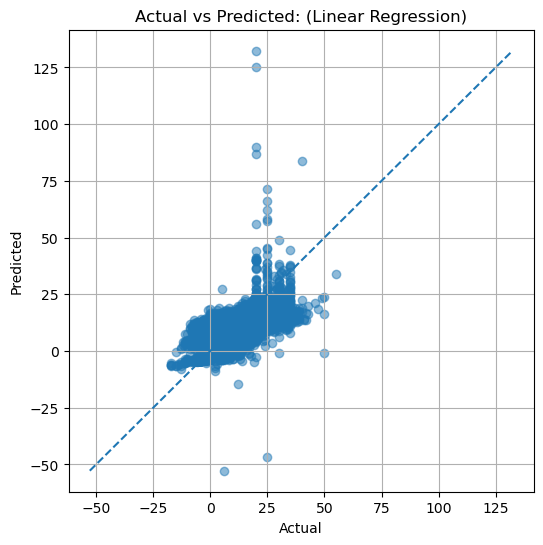

In [16]:
# ---------------------------------------------------------
# Baseline Model: Linear Regression
# ---------------------------------------------------------
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

y_train = np.asarray(y_train).ravel()
y_test  = np.asarray(y_test).ravel()
y_val   = np.asarray(y_val).ravel()

baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

y_pred_test = baseline_model.predict(X_test_scaled)
y_pred_val  = baseline_model.predict(X_val_scaled)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Print results
print("=== Linear Regression Baseline Performance ===")
print(f"Test Set:       RMSE = {rmse_test:.3f}, MAE = {mae_test:.3f}, R² = {r2_test:.3f}")
print(f"Validation Set: RMSE = {rmse_val:.3f}, MAE = {mae_val:.3f}, R² = {r2_val:.3f}")

# Sample predictions
comparison_df = pd.DataFrame({
    "Actual": y_test[:10],
    "Predicted": y_pred_test[:10]
})
print("\nSample Predictions:")
print(comparison_df)

# Actual vs Predicted scatter plot for test set
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
maxv = max(np.max(y_test), np.max(y_pred_test))
minv = min(np.min(y_test), np.min(y_pred_test))
plt.plot([minv, maxv], [minv, maxv], linestyle='--') 
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: (Linear Regression)")
plt.grid(True)
plt.show()

## XGBoost: Training Job and Model Creation

In [17]:
# Create training job
job_name = "nutrition-score-xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = f"s3://{bucket}/{prefix}/output/{job_name}"

# Specify model
image = sagemaker.image_uris.retrieve(framework="xgboost", region=region, version="1.7-1")
instance_type = 'ml.m5.xlarge'
model_name = job_name

# Set estimator
sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type=instance_type,
    output_path=output_location,
    sagemaker_session=sess,
)

# Set hyperparameters for regression
sm_estimator.set_hyperparameters(
    objective="reg:squarederror",
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    num_round=100,
)

# Set input locations for train and val sets
train_data = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train", content_type="text/csv"
)
val_data = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validation", content_type="text/csv"
)
data_channels = {"train": train_data, "validation": val_data}

# Launch training job
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=True)

INFO:sagemaker:Creating training-job with name: nutrition-score-xgb-2025-10-17-05-20-36


2025-10-17 05:20:37 Starting - Starting the training job...
2025-10-17 05:20:52 Starting - Preparing the instances for training...
2025-10-17 05:21:39 Downloading - Downloading the training image......
2025-10-17 05:22:35 Training - Training image download completed. Training in progress..../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-10-17 05:22:45.514 ip-10-0-101-52.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-10-17 05:22:45.574 ip-10-0-101-52.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-10-17:05:22:45:INFO] Imported framework sagemaker_xgboost_container.training
[2025-10-17:05:22:45:INFO] Failed to parse hyperparamete

## Batch Transform Job for Test Predictions

In [18]:
# Create transformer object from trained estimator
transformer = sm_estimator.transformer(
    instance_count=1,
    instance_type=instance_type
)

# Start the batch transform job
transformer.transform(
    data=test_features_only_s3_path,
    content_type='text/csv'
)

# Wait for the job to complete
print("Batch Transform job started. Waiting for completion...")
transformer.wait()
print("Job complete.")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-10-17-05-23-57-260
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-10-17-05-23-58-043


...........................
/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-10-17:05:28:29:INFO] No GPUs detected (normal if no gpus installed)
[2025-10-17:05:28:29:INFO] No GPUs detected (normal if no gpus installed)
[2025-10-17:05:28:29:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invoca

## Compare Model Performance

In [20]:
# Calculate performance on test set

# S3 location of the prediction results
output_s3_path = transformer.output_path

# Download the prediction results into a pandas DataFrame
predictions_df = pd.read_csv(f"{output_s3_path}/{test_features_only_file}.out", header=None)
predictions_df

,0
0,15.861562
1,16.359510
2,-2.909233
3,-5.045939
4,10.388537
...,...
9957,8.606663
9958,26.822006
9959,9.852825
9960,31.059971


In [32]:
# Calculate performance metrics
predictions = predictions_df[0]
rmse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"XGBoost Model Performance:")
print(f"RMSE: {rmse}")
print(f"MAE:  {mae}")
print(f"R²:   {r2}")

XGBoost Model Performance:
RMSE: 7.4535577072189545
MAE:  2.1324712740421408
R²:   0.931208949537239


In [42]:

# Compare Baseline (Linear Regression) vs XGBoost Model

print("\nModel Comparison: Linear Regression vs XGBoost")

# Baseline metrics (Linear Regression)
print("\nLinear Regression (Baseline) on Test Set")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE:  {mae_test:.3f}")
print(f"R²:   {r2_test:.3f}")

# XGBoost metrics
print("\nXGBoost Model on Test Set")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

# Improvement Summary
rmse_improvement = rmse_test - rmse_test_xgb
r2_improvement = (r2_test_xgb - r2_test) / r2_test * 100 if r2_test != 0 else float('inf')

print("\nPerformance Improvement")
print(f"XGBoost reduced RMSE by {rmse_improvement:.3f} points compared to baseline.")
print(f"XGBoost improved R² by {r2_improvement:.1f}% over Linear Regression.")



Model Comparison: Linear Regression vs XGBoost

Linear Regression (Baseline) on Test Set
RMSE: 8.194
MAE:  6.414
R²:   0.380

XGBoost Model on Test Set
RMSE: 7.454
MAE:  2.132
R²:   0.931

Performance Improvement
XGBoost reduced RMSE by 0.740 points compared to baseline.
XGBoost improved R² by 144.8% over Linear Regression.


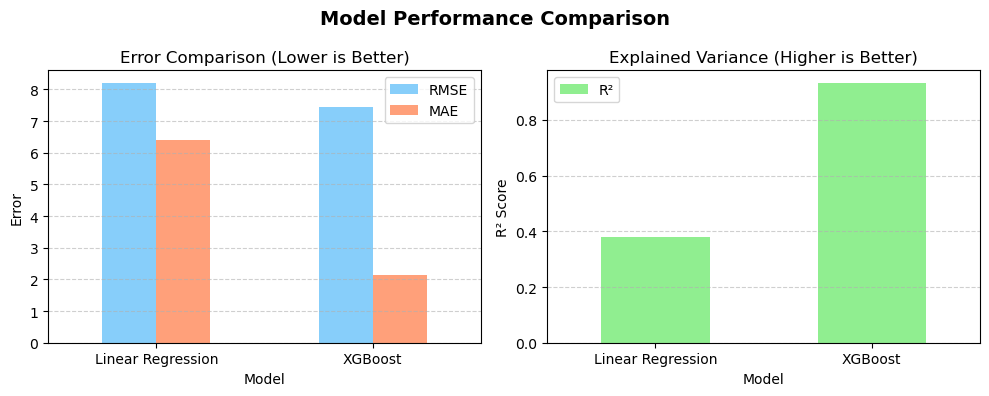

In [43]:
# Plot RMSE and MAE 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

comparison_df[["RMSE", "MAE"]].plot(kind="bar", ax=axes[0], rot=0, color=["#87CEFA", "#FFA07A"])
axes[0].set_title("Error Comparison (Lower is Better)")
axes[0].set_ylabel("Error")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

#  Plot R² 
comparison_df[["R²"]].plot(kind="bar", ax=axes[1], rot=0, color=["#90EE90"])
axes[1].set_title("Explained Variance (Higher is Better)")
axes[1].set_ylabel("R² Score")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Model Performance Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


Nutritional and ingredient-based features in the dataset interact in complex, non-linear ways that are better captured by tree-based methods. The baseline linear model could only approximate broad linear relationships between features (e.g., energy or sugar content) and NutriScore, whereas XGBoost effectively modeled higher-order dependencies—such as how combinations of fats, sugars, and additives jointly influence nutritional quality

## Upload Trained XGBoost Model to SageMaker Model Registry

In [23]:
# Initialize the sagemaker client
sagemaker_client = boto3.client("sagemaker")

# Get the S3 path to the trained model artifacts
info = sagemaker_client.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model artifacts are located at: {model_data}")

# Define the container image for inference (we defined 'image' earlier)
primary_container = {"Image": image, "ModelDataUrl": model_data}

# Save model to Sagemaker Model Registry
create_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=primary_container
)

print(f"\nSuccessfully created model: {create_model_response['ModelArn']}")

Model artifacts are located at: s3://sagemaker-us-east-1-381492037991/nutriscore-prediction-xgboost/output/nutrition-score-xgb-2025-10-17-05-20-36/nutrition-score-xgb-2025-10-17-05-20-36/output/model.tar.gz

Successfully created model: arn:aws:sagemaker:us-east-1:381492037991:model/nutrition-score-xgb-2025-10-17-05-20-36


In [24]:
# View model name
model_name

'nutrition-score-xgb-2025-10-17-05-20-36'